# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=10,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-02-37/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4489 | MulticlassF1Score=0.1237
Batch-30 : CrossEntropyLoss=2.4832 | MulticlassF1Score=0.1903
Batch-45 : CrossEntropyLoss=2.4463 | MulticlassF1Score=0.2286
Batch-60 : CrossEntropyLoss=2.4450 | MulticlassF1Score=0.2659
Batch-75 : CrossEntropyLoss=2.4265 | MulticlassF1Score=0.3028
Batch-90 : CrossEntropyLoss=2.4014 | MulticlassF1Score=0.3396
Batch-105: CrossEntropyLoss=2.3701 | MulticlassF1Score=0.3743
Batch-120: CrossEntropyLoss=2.3773 | MulticlassF1Score=0.4010
Batch-135: CrossEntropyLoss=2.3685 | MulticlassF1Score=0.4263
Batch-150: CrossEntropyLoss=2.3518 | MulticlassF1Score=0.4516
Batch-165: CrossEntropyLoss=2.3502 | MulticlassF1Score=0.4715
Batch-180: CrossEntropyLoss=2.3447 | MulticlassF1Score=0.4876
Batch-195: CrossEntropyLoss=2.3407 | MulticlassF1Score=0.5023
Batch-210: CrossEntropyLoss=2.3600 | MulticlassF1Score=0.5140
Batch-225: CrossEntropyLoss=2.3479 | MulticlassF1Score=0.5252
Batch-226: CrossEntropyLoss=2.3484 | MulticlassF1Score=0.5256

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3723 | MulticlassF1Score=0.6739
Batch-30 : CrossEntropyLoss=2.3648 | MulticlassF1Score=0.6700
Batch-45 : CrossEntropyLoss=2.3389 | MulticlassF1Score=0.6716
Batch-60 : CrossEntropyLoss=2.3588 | MulticlassF1Score=0.6711
Batch-63 : CrossEntropyLoss=2.3559 | MulticlassF1Score=0.6715

Training   : Mean CrossEntropyLoss = 2.4056 | Mean MulticlassF1Score = 0.3612
Validation : Mean CrossEntropyLoss = 2.3497 | Mean MulticlassF1Score = 0.6731

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3448 | MulticlassF1Score=0.6752
Batch-30 : CrossEntropyLoss=2.3498 | MulticlassF1Score=0.6784
Batch-45 : CrossEntropyLoss=2.3306 | MulticlassF1Score=0.6808
Batch-60 : CrossEntropyLoss=2.3548 | MulticlassF1Score=0.6837
Batch-75 : CrossEntropyLoss=2.3375 | MulticlassF1Score=0.6828
Batch-90 : CrossEntropyLoss=2.3425 | MulticlassF1Score=0.6833
Batch-105: CrossEntropyLoss=2.3494 | MulticlassF1Score=0.6831
Batch-120: CrossEntropyLoss=2.3329 | MulticlassF1Score=0.6824
Batch-135: CrossEntropyLoss=2.3501 | MulticlassF1Score=0.6804
Batch-150: CrossEntropyLoss=2.3329 | MulticlassF1Score=0.6836
Batch-165: CrossEntropyLoss=2.3407 | MulticlassF1Score=0.6867
Batch-180: CrossEntropyLoss=2.3321 | MulticlassF1Score=0.6892
Batch-195: CrossEntropyLoss=2.3300 | MulticlassF1Score=0.6918
Batch-210: CrossEntropyLoss=2.3273 | MulticlassF1Score=0.6936
Batch-225: CrossEntropyLoss=2.3232 | MulticlassF1Score=0.6982
Batch-226: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.6984

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3325 | MulticlassF1Score=0.7722
Batch-30 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7774
Batch-45 : CrossEntropyLoss=2.3288 | MulticlassF1Score=0.7776
Batch-60 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7766
Batch-63 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7770

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3419 | Mean MulticlassF1Score = 0.6841
Validation : Mean CrossEntropyLoss = 2.3182 | Mean MulticlassF1Score = 0.7748

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7871
Batch-30 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7892
Batch-45 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7917
Batch-60 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7921
Batch-75 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7931
Batch-90 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7938
Batch-105: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7938
Batch-120: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7935
Batch-135: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7942
Batch-150: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7933
Batch-165: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7929
Batch-180: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7931
Batch-195: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7936
Batch-210: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7932
Batch-225: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.7931
Batch-226: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7931

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7884
Batch-30 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7875
Batch-45 : CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7892
Batch-60 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7908
Batch-63 : CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7910

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7922
Validation : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7882

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7982
Batch-30 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7977
Batch-45 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7978
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8020
Batch-75 : CrossEntropyLoss=2.3206 | MulticlassF1Score=0.8041
Batch-90 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8050
Batch-105: CrossEntropyLoss=2.3149 | MulticlassF1Score=0.8042
Batch-120: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8039
Batch-135: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8041
Batch-150: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.8043
Batch-165: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8035
Batch-180: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8040
Batch-195: CrossEntropyLoss=2.3133 | MulticlassF1Score=0.8047
Batch-210: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8050
Batch-225: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8049
Batch-226: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8050

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8005
Batch-30 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7990
Batch-45 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.7984
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8005
Batch-63 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8006

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3083 | Mean MulticlassF1Score = 0.8031
Validation : Mean CrossEntropyLoss = 2.3092 | Mean MulticlassF1Score = 0.7994

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8074
Batch-30 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8072
Batch-45 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.8059
Batch-60 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8077
Batch-75 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8084
Batch-90 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8076
Batch-105: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8072
Batch-120: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8074
Batch-135: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8083
Batch-150: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8097
Batch-165: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8106
Batch-180: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8112
Batch-195: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8117
Batch-210: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8124
Batch-225: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8141
Batch-226: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8142

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8276
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8278
Batch-45 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8296
Batch-60 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8298
Batch-63 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8296

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3053 | Mean MulticlassF1Score = 0.8089
Validation : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8275

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8388
Batch-30 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8386
Batch-45 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8402
Batch-60 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8403
Batch-75 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8397
Batch-90 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8401
Batch-105: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8402
Batch-120: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8403
Batch-135: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8403
Batch-150: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8404
Batch-165: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8405
Batch-180: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8405
Batch-195: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8409
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8408
Batch-225: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8407
Batch-226: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8376
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8338
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8339
Batch-60 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8330
Batch-63 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8322

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8400
Validation : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8365

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8467
Batch-30 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8446
Batch-45 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8440
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8431
Batch-75 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8431
Batch-90 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8434
Batch-105: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8437
Batch-120: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8437
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8429
Batch-150: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8428
Batch-165: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8422
Batch-180: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8423
Batch-195: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8426
Batch-210: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8427
Batch-225: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8425
Batch-226: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8378
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8374
Batch-45 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8342
Batch-63 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8345

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8436
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8371

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8349
Batch-30 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8380
Batch-45 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8406
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8408
Batch-75 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8418
Batch-90 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8422
Batch-105: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8441
Batch-120: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8468
Batch-135: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8491
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8512
Batch-165: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8529
Batch-180: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8547
Batch-195: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8560
Batch-210: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8570
Batch-225: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8583
Batch-226: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8584

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8626
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8652
Batch-45 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8622
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8633
Batch-63 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8627

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8465
Validation : Mean CrossEntropyLoss = 2.2902 | Mean MulticlassF1Score = 0.8648

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8700
Batch-30 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8723
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8721
Batch-60 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8736
Batch-75 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8753
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8752
Batch-105: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8744
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8745
Batch-135: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8741
Batch-150: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8736
Batch-165: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8736
Batch-180: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8738
Batch-195: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8738
Batch-210: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8735
Batch-225: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8733
Batch-226: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8734

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8630
Batch-30 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8643
Batch-45 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8632
Batch-60 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8641
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8647

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2870 | Mean MulticlassF1Score = 0.8735
Validation : Mean CrossEntropyLoss = 2.2894 | Mean MulticlassF1Score = 0.8651

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8750
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8750
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8756
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8748
Batch-75 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8738
Batch-90 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8733
Batch-105: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8745
Batch-120: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8754
Batch-135: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8755
Batch-150: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8759
Batch-165: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8764
Batch-180: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8771
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8781
Batch-210: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8793
Batch-225: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8801
Batch-226: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8802

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8784
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8792
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8817
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8816
Batch-63 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8814

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8757
Validation : Mean CrossEntropyLoss = 2.2847 | Mean MulticlassF1Score = 0.8786

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8957
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8959
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8949
Batch-75 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8947
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8950
Batch-105: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8945
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8947
Batch-135: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8946
Batch-150: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8948
Batch-165: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8946
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8946
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8944
Batch-210: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8944
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8940
Batch-226: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8842
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8808
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8831
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8844
Batch-63 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8840

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8944
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8833

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8967
Batch-30 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8978
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8971
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8966
Batch-90 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8975
Batch-105: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8968
Batch-120: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8968
Batch-135: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8973
Batch-150: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8968
Batch-165: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8964
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8962
Batch-195: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8961
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.8965
Batch-225: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8966
Batch-226: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8966

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8845
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8875
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8843
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8843
Batch-63 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8846

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8969
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8845

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8985
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8970
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8984
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8991
Batch-75 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8988
Batch-90 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8987
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8988
Batch-135: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8983
Batch-150: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8988
Batch-165: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8989
Batch-180: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8988
Batch-195: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8988
Batch-210: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8988
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8986
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8987

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8857
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8877
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8877
Batch-60 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8877
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.8880

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8988
Validation : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8866

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9031
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9030
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9035
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9035
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9037
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9031
Batch-105: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9027
Batch-120: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9025
Batch-135: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9031
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9030
Batch-165: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9027
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9027
Batch-195: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9031
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9029
Batch-225: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9026
Batch-226: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9027

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8883
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8881
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8891
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8900
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8904

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9029
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8890

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9002
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9037
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9036
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9037
Batch-75 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9036
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9046
Batch-105: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9045
Batch-120: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9043
Batch-135: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9042
Batch-150: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9041
Batch-165: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9044
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9047
Batch-195: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9046
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9047
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9045
Batch-226: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9045

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8891
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8902
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8895
Batch-63 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8900

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9036
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8887

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.9095
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9100
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9082
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9074
Batch-75 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9071
Batch-90 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9068
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9092
Batch-120: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9120
Batch-135: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9141
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9158
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9171
Batch-180: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9186
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9196
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9206
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9217
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9217

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9192
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9198
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9196

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9127
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9183

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9332
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9346
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9348
Batch-90 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9348
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9349
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9345
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9343
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9342
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9339
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9340
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9343
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9345
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9345
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9345

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9178
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9194
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9194

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9341
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9185

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9350
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9361
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9366
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9365
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9365
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9358
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9356
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9354
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9355
Batch-226: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9355

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9201
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9187
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9194

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9362
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9196

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9370
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9367
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9364
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9362
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9363
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9361
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9197

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9366
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9229

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9372
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9365
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9372
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9372
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9370
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9370
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9372
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9373
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9369
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9369

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9193
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9195

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9370
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9192

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9392
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9392
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9381
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9381
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9380
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9381
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9374
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9375
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9206

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9381
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9211

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9364
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9366
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9373
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9374
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9377
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9381
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9385
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9385
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9383
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9383
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9382
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9387
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9205
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9208

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9206

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9404
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9401
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9405
Batch-90 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9403
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9396
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9394
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9205

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9399
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9220

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9395
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9397
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9399
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9398
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9205
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9205

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9399
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9219

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9383
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9390
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9395
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9394
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9394
Batch-180: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9199
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9202

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9219
Patience = 1/50❗

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9406
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9408
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9409
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9401
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9400
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9401
Batch-225: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9399
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9399

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9211

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9402
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9227

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9399
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9492
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9500
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9509
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9509

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9417
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9415

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9422

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9621
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9626
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9625
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9626
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9630
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9632
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9632
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9635
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9636
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9448

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9630
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9448

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9656

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9449

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9660
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9661
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9661
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9660
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9447

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9639
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9648
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9659
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9452

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9460
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9678
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9664
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9466

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9661
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9451

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9449

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9448

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9479

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9461

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9492

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2511 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9477

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9706
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9490

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2503 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9507

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9719
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9718
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9484

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9484

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9489
Patience = 3/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9737
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9479

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9719
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9721
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9709
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9724
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9724

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9538
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9543
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9541
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9536
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9536

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2619 | Mean MulticlassF1Score = 0.9542

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9759
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9761
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9760
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9765
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9766
Batch-90 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9770
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9768
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9767
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9767
Batch-150: CrossEntropyLoss=2.2517 | MulticlassF1Score=0.9766
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9766
Batch-180: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9765
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9766
Batch-210: CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9767
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9768
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9768

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9549
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9546
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9543
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9537
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9533

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2547 | Mean MulticlassF1Score = 0.9765
Validation : Mean CrossEntropyLoss = 2.2619 | Mean MulticlassF1Score = 0.9545

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9757
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9773
Batch-45 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9773
Batch-60 : CrossEntropyLoss=2.2514 | MulticlassF1Score=0.9770
Batch-75 : CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9776
Batch-90 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9773
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9772
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9773
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9774
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9772
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9771
Batch-180: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9771
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9772
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9771
Batch-225: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9771
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9771

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9553
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9543
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9550
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9544
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9537

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2545 | Mean MulticlassF1Score = 0.9771
Validation : Mean CrossEntropyLoss = 2.2619 | Mean MulticlassF1Score = 0.9541

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9809
Batch-30 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9779
Batch-45 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9776
Batch-60 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9770
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9774
Batch-90 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9776
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9772
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9771
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9771
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9771
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9771
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9771
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9771
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9770
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9772
Batch-226: CrossEntropyLoss=2.2512 | MulticlassF1Score=0.9772

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9570
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9549
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9549
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9543
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9542

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2544 | Mean MulticlassF1Score = 0.9775
Validation : Mean CrossEntropyLoss = 2.2617 | Mean MulticlassF1Score = 0.9548

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9774
Batch-30 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9777
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9773
Batch-60 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9772
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9771
Batch-90 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9774
Batch-105: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9774
Batch-120: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9777
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9778
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9776
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9775
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9774
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9773
Batch-210: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9773
Batch-225: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9774
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9774

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9556
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9534
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9531
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9539
Batch-63 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9541

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2544 | Mean MulticlassF1Score = 0.9776
Validation : Mean CrossEntropyLoss = 2.2617 | Mean MulticlassF1Score = 0.9543

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9784
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9777
Batch-45 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9774
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9776
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9780
Batch-90 : CrossEntropyLoss=2.2512 | MulticlassF1Score=0.9780
Batch-105: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9781
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9777
Batch-135: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9777
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9777
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9776
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9777
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9777
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9776
Batch-225: CrossEntropyLoss=2.2503 | MulticlassF1Score=0.9776
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9776

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9530
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9527
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9535
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9540
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9537

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2543 | Mean MulticlassF1Score = 0.9777
Validation : Mean CrossEntropyLoss = 2.2617 | Mean MulticlassF1Score = 0.9527

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9778
Batch-30 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9777
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9784
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9780
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9781
Batch-90 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9781
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9784
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9780
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9781
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9780
Batch-165: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9782
Batch-180: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9779
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9778
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9778
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9777
Batch-226: CrossEntropyLoss=2.2500 | MulticlassF1Score=0.9778

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9562
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9548
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9542
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9538
Batch-63 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9542

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2543 | Mean MulticlassF1Score = 0.9779
Validation : Mean CrossEntropyLoss = 2.2616 | Mean MulticlassF1Score = 0.9555

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2543
Best CrossEntropyLoss training    : 2.2616
Best MulticlassF1Score validation : 0.9779
Best MulticlassF1Score validation : 0.9555
Training duration                 : 2.6187 minutes.
Training date                     : 2022-10-19 13:53:34.696410+08:00


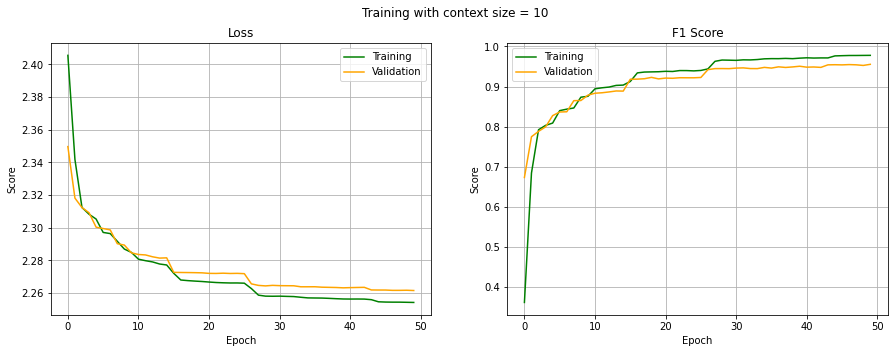

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9784, device='cuda:0'),
 tensor(0.9542, device='cuda:0'),
 tensor(0.9544, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9784, device='cuda:0'),
 tensor(0.9542, device='cuda:0'),
 tensor(0.9544, device='cuda:0'))

## Heatmap

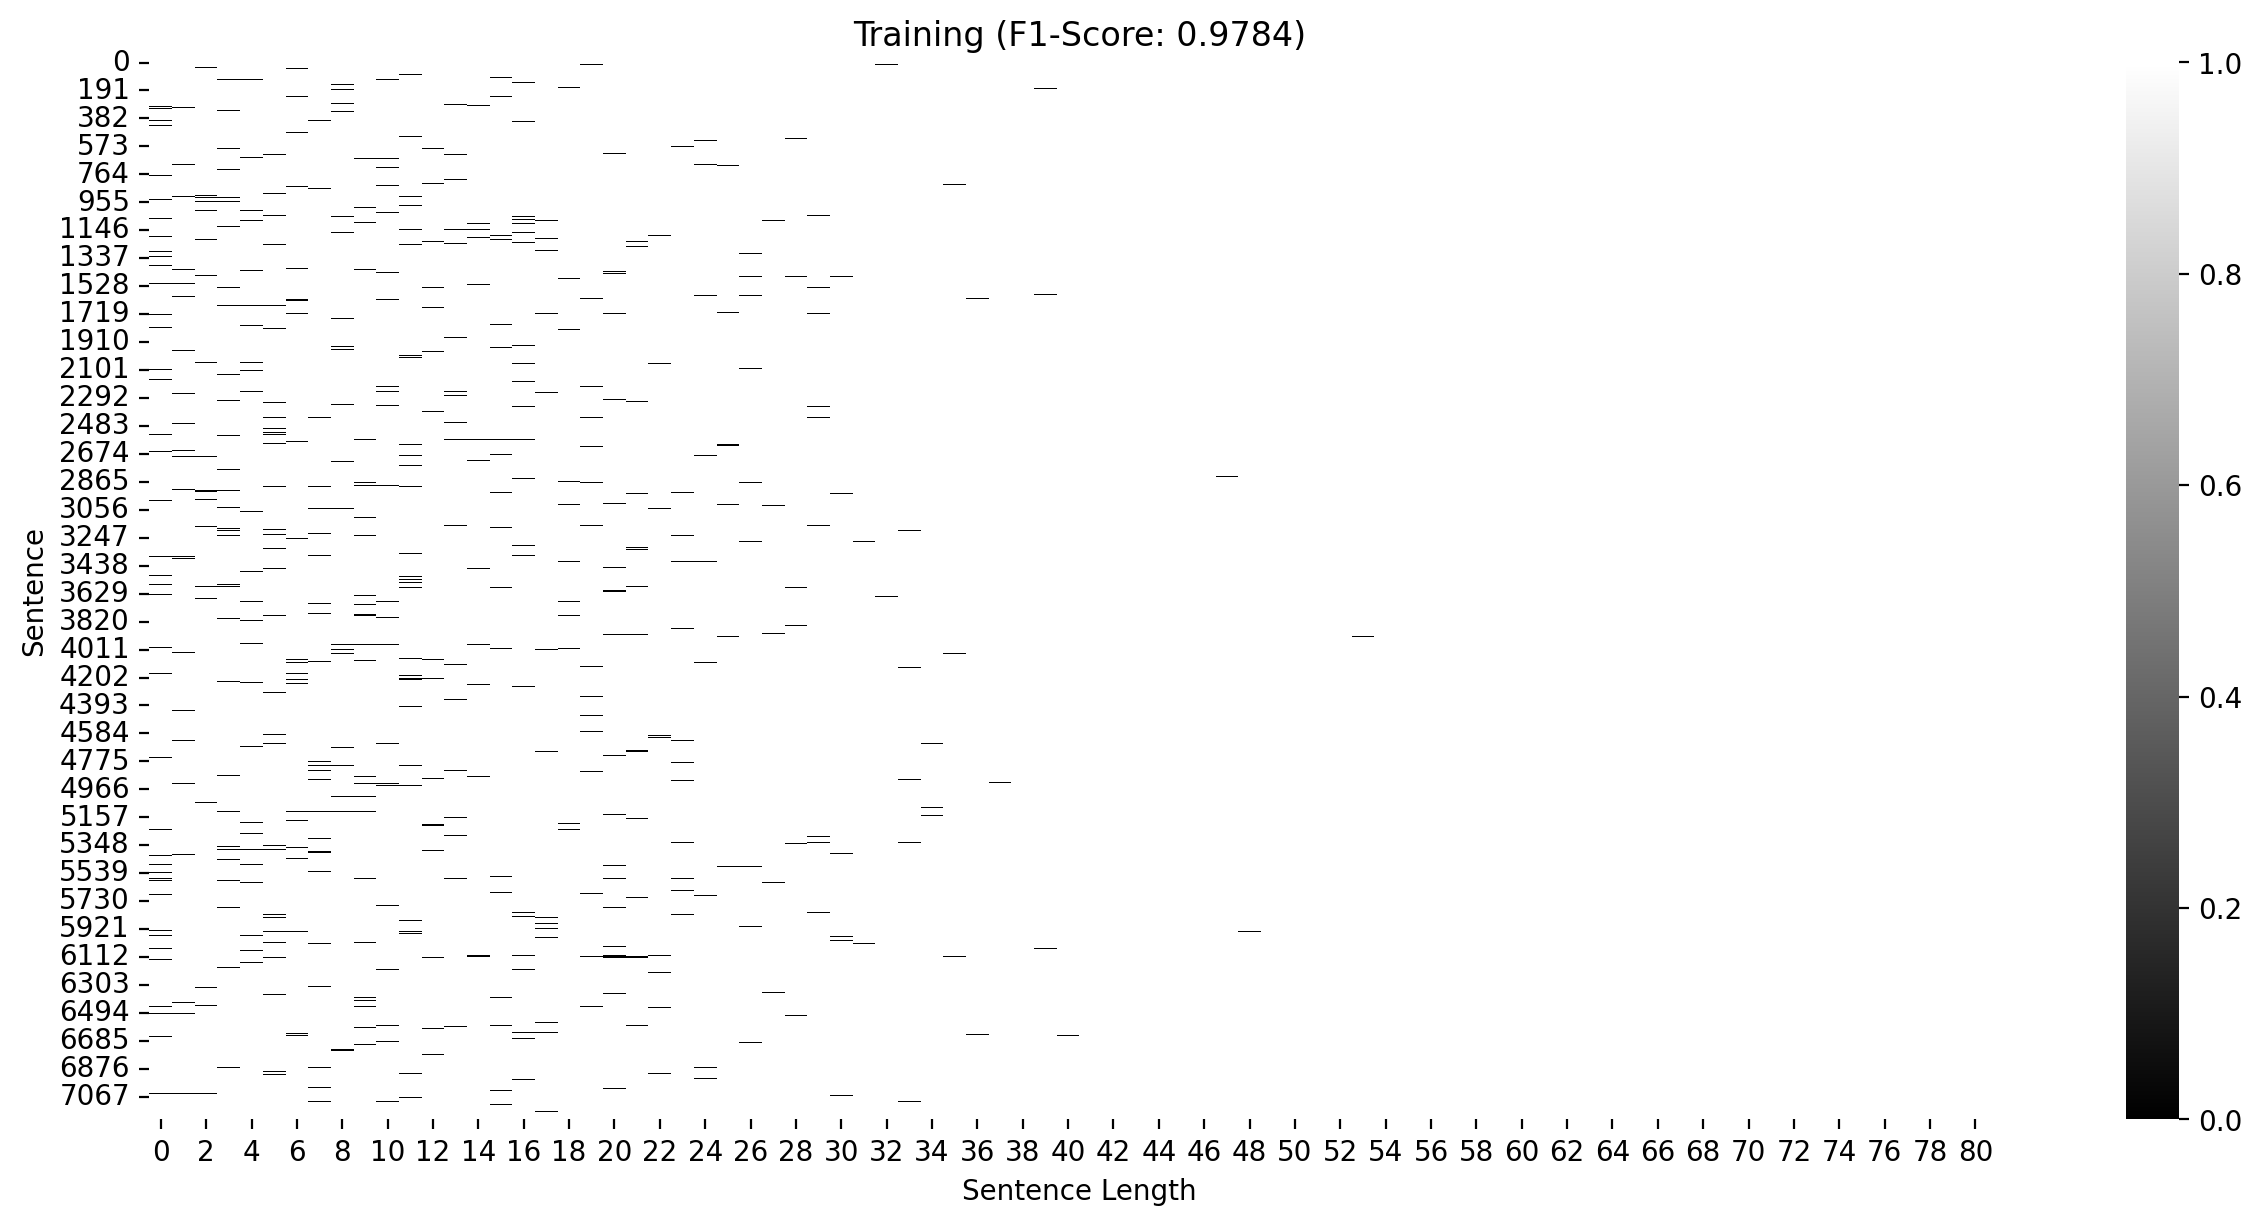

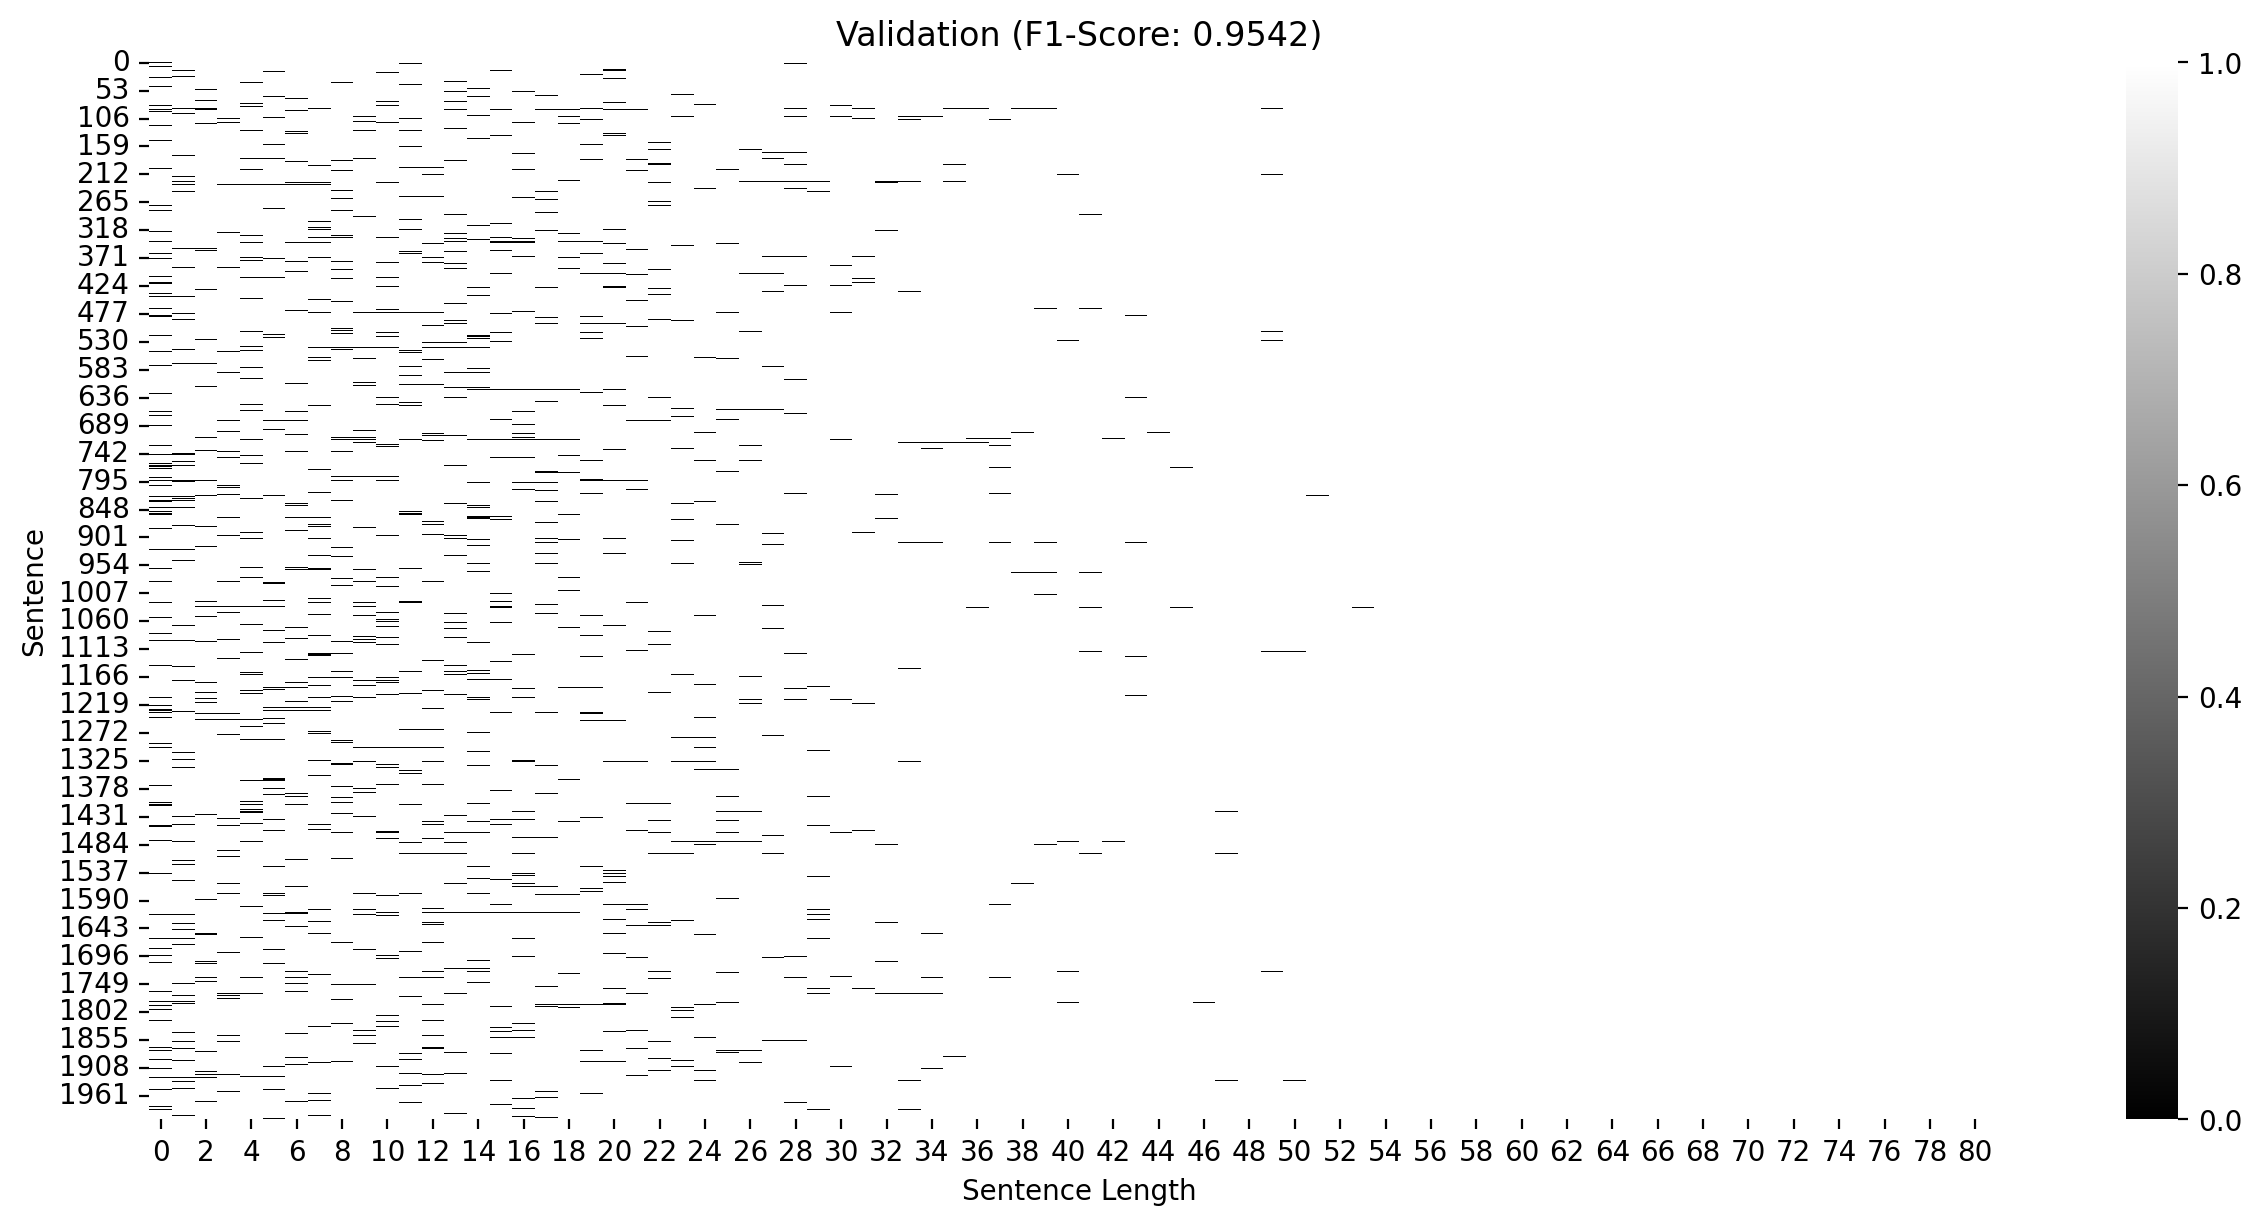

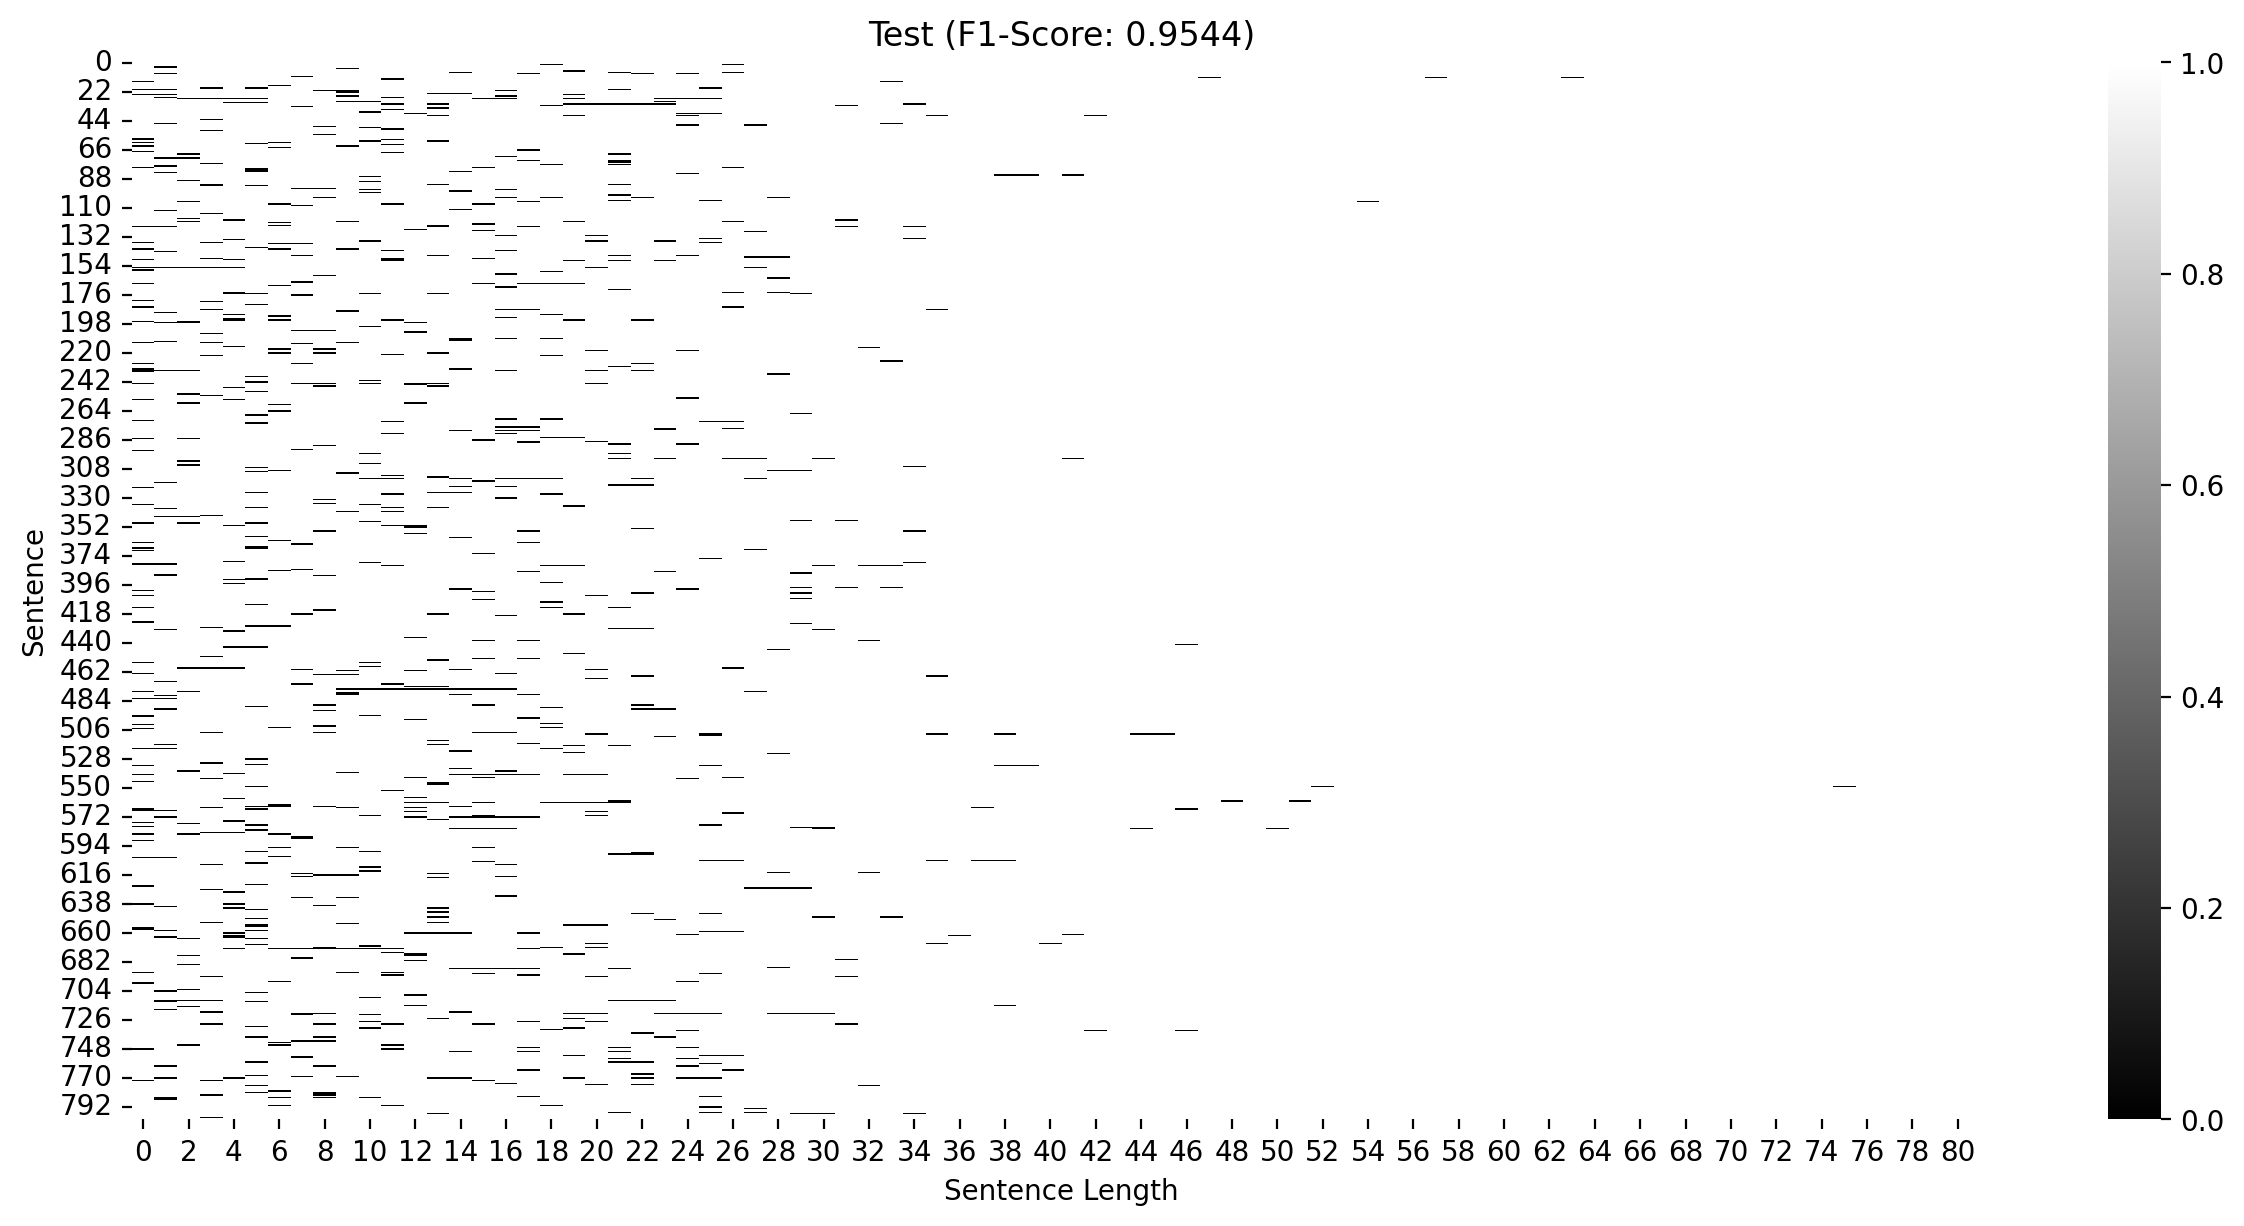

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


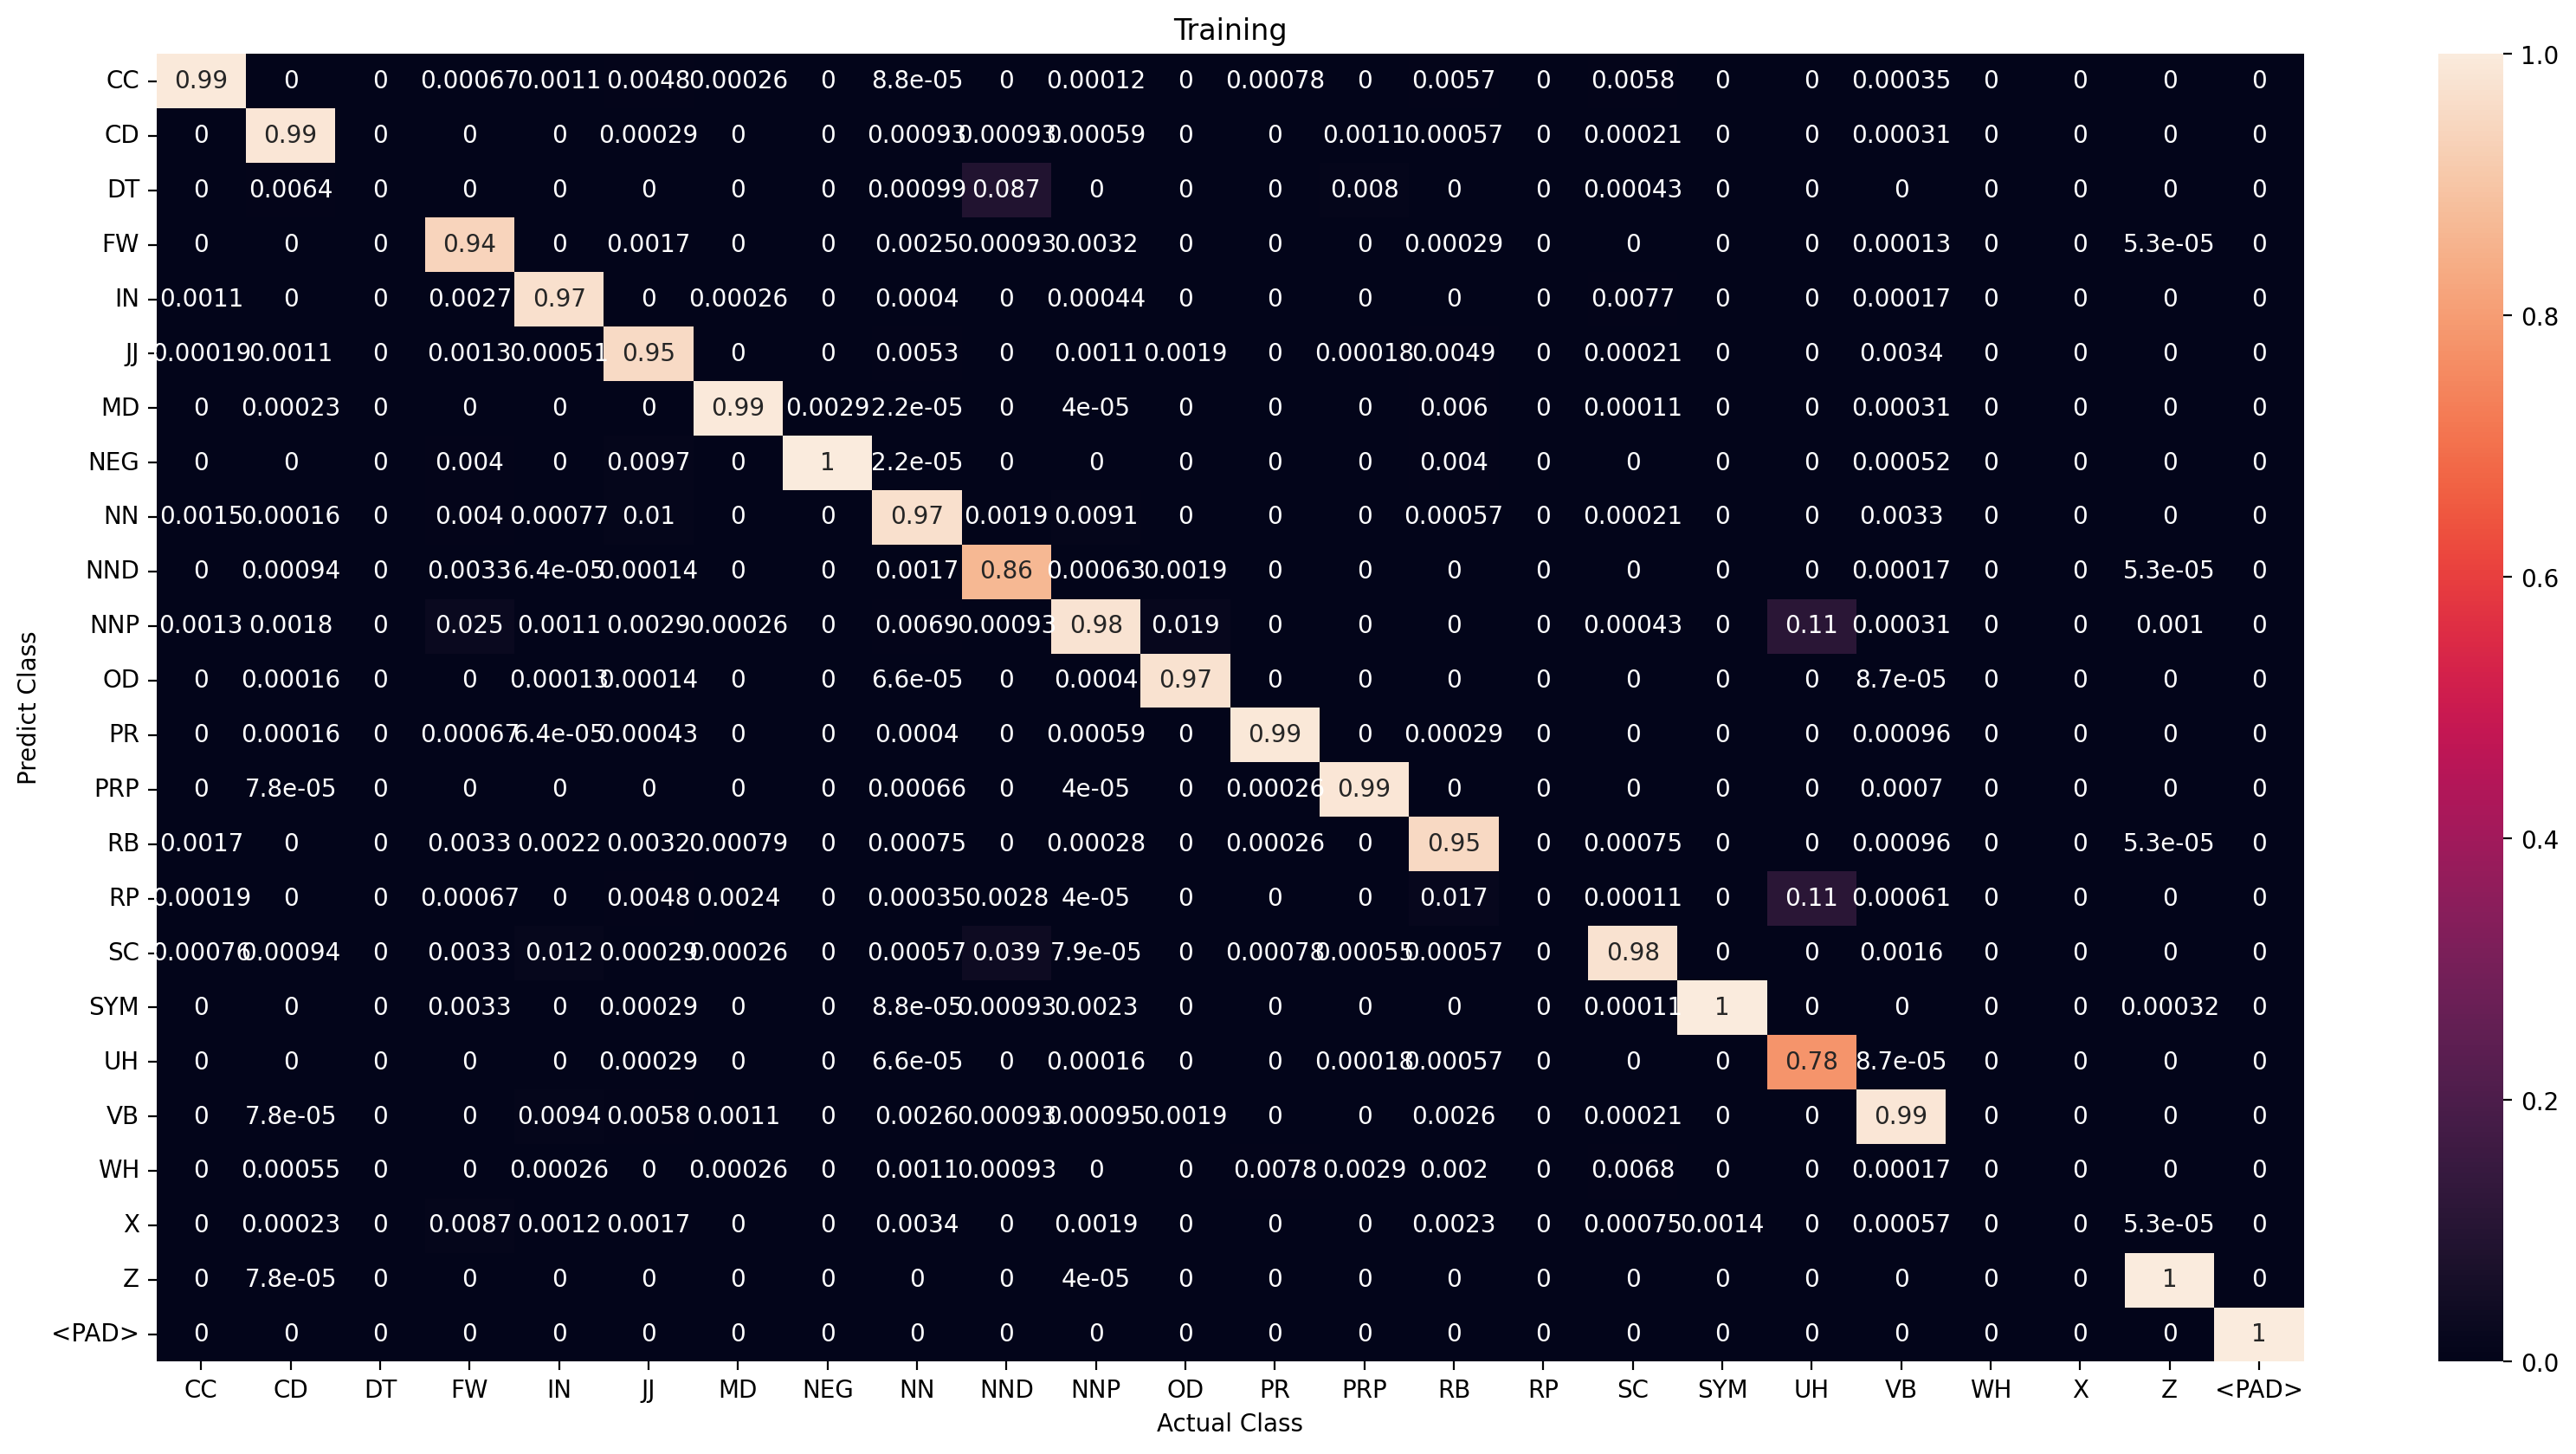

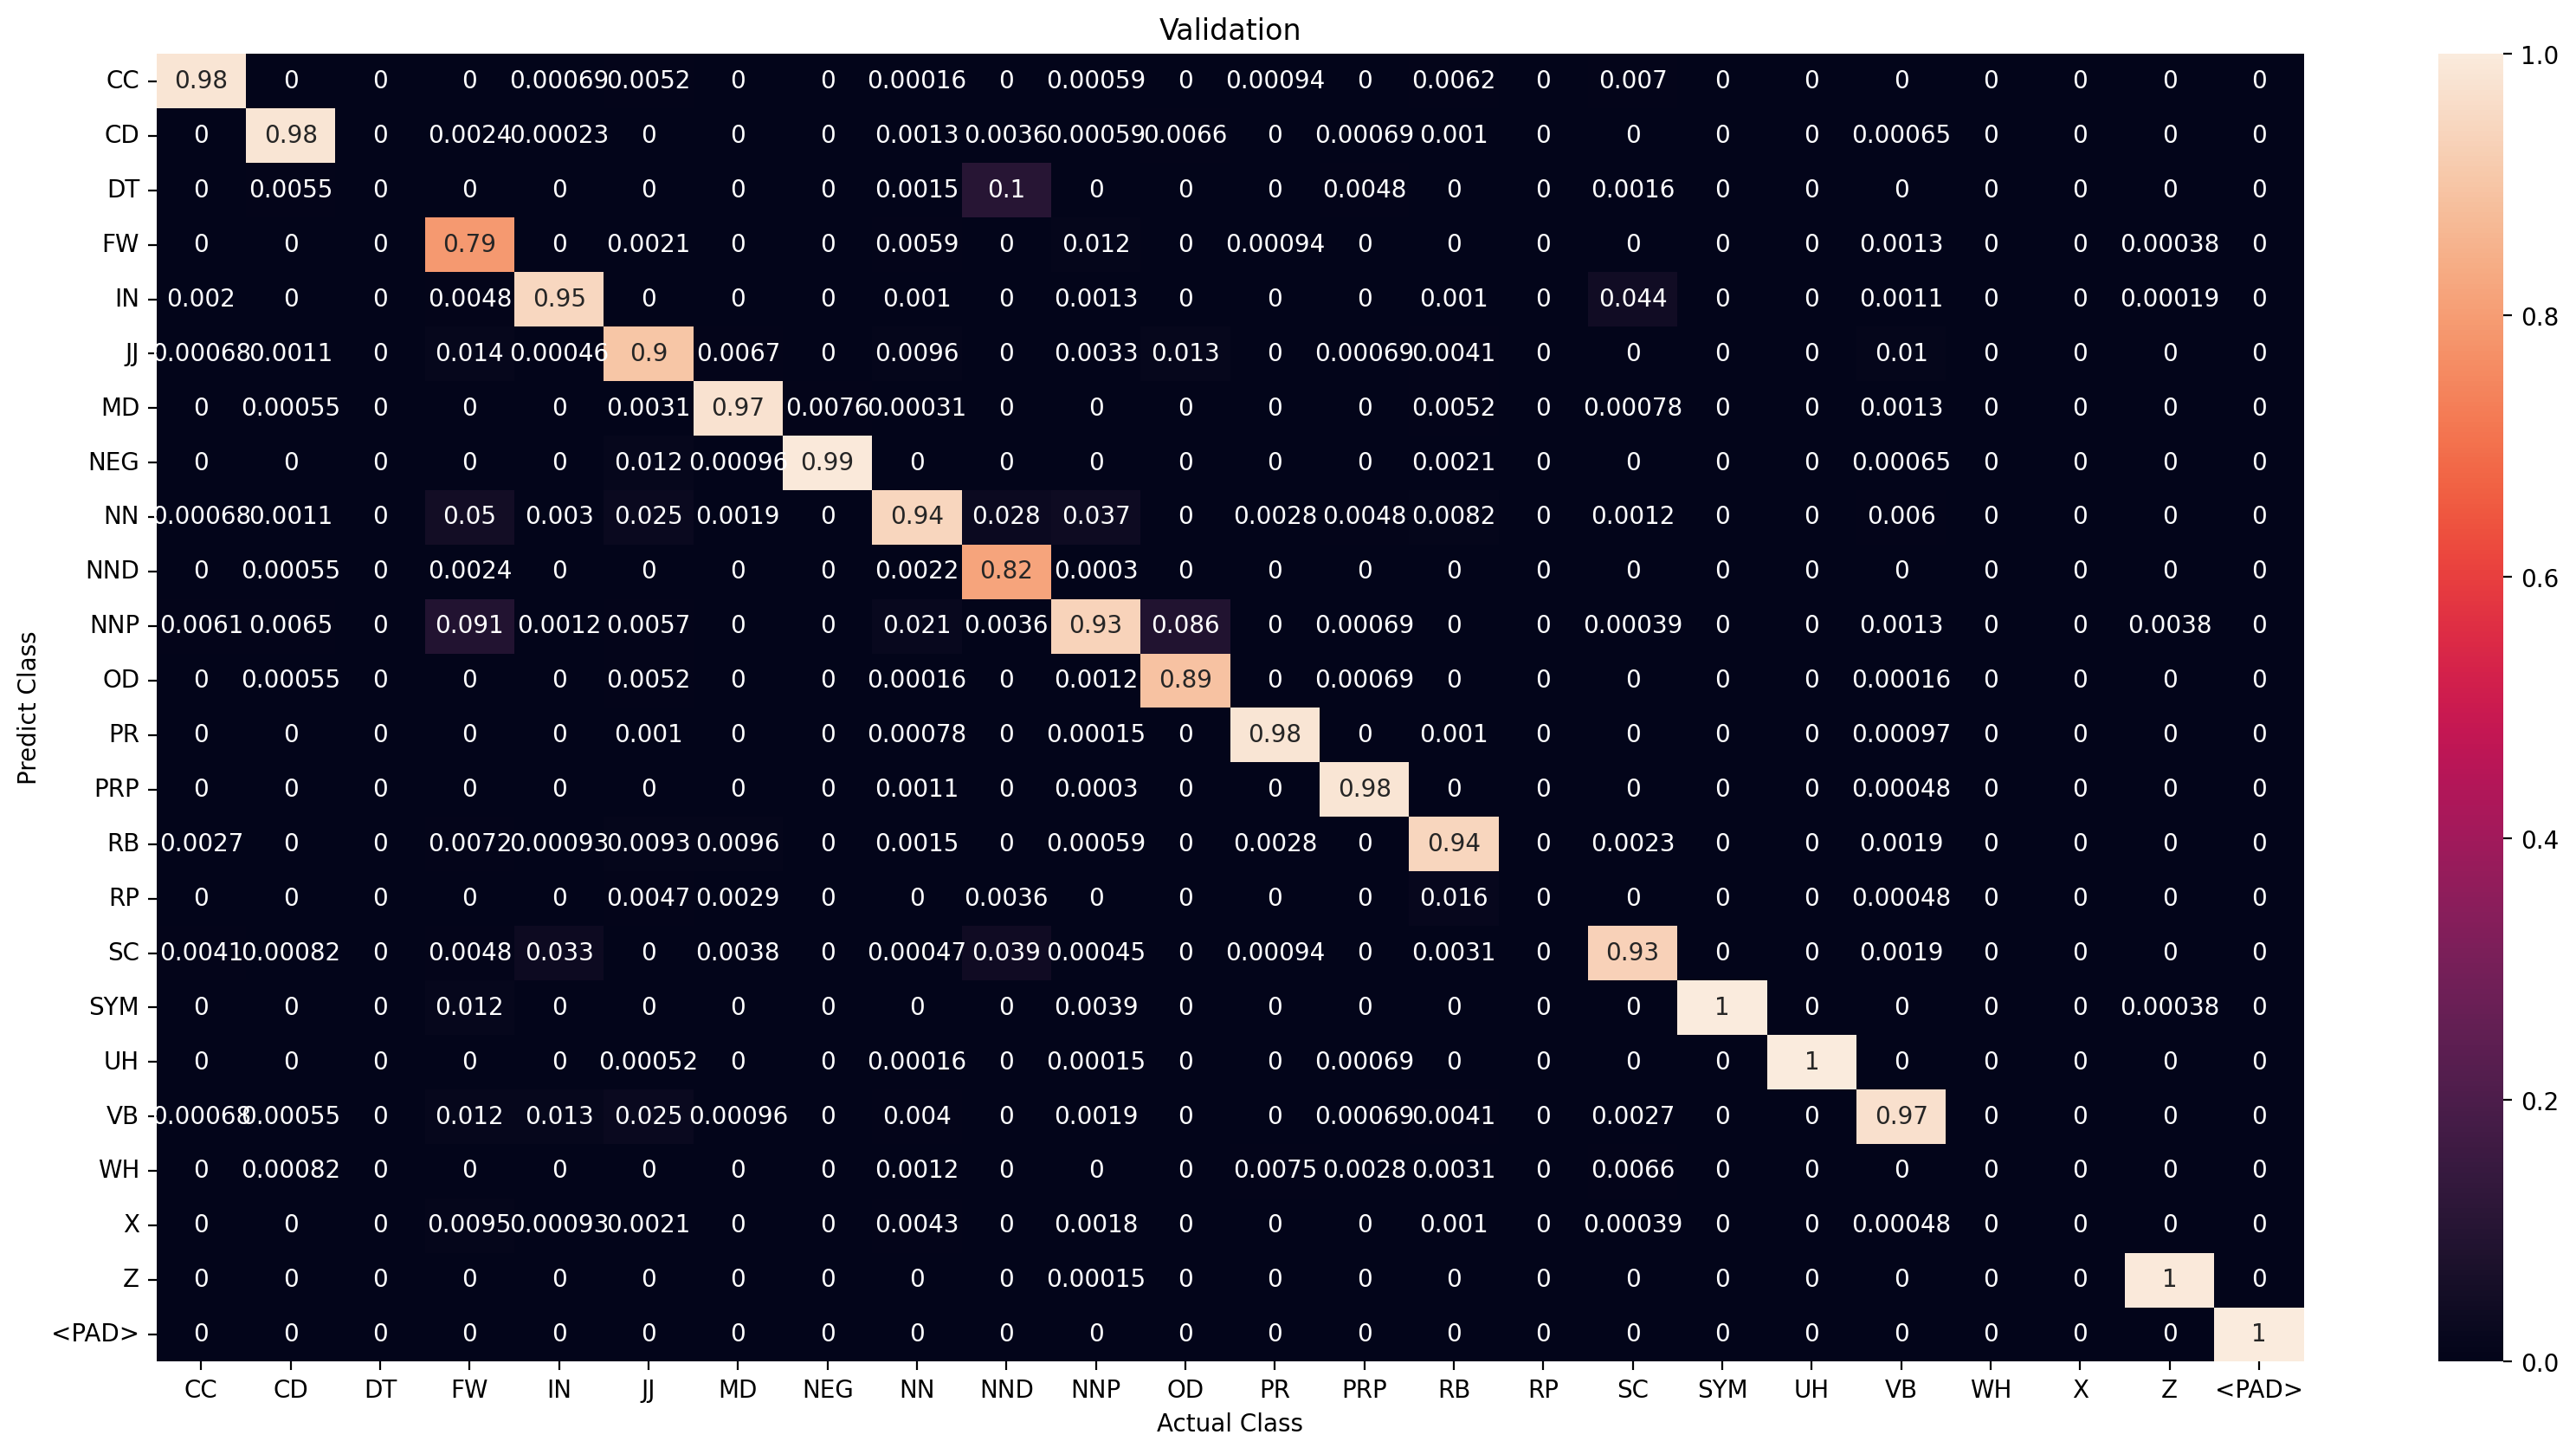

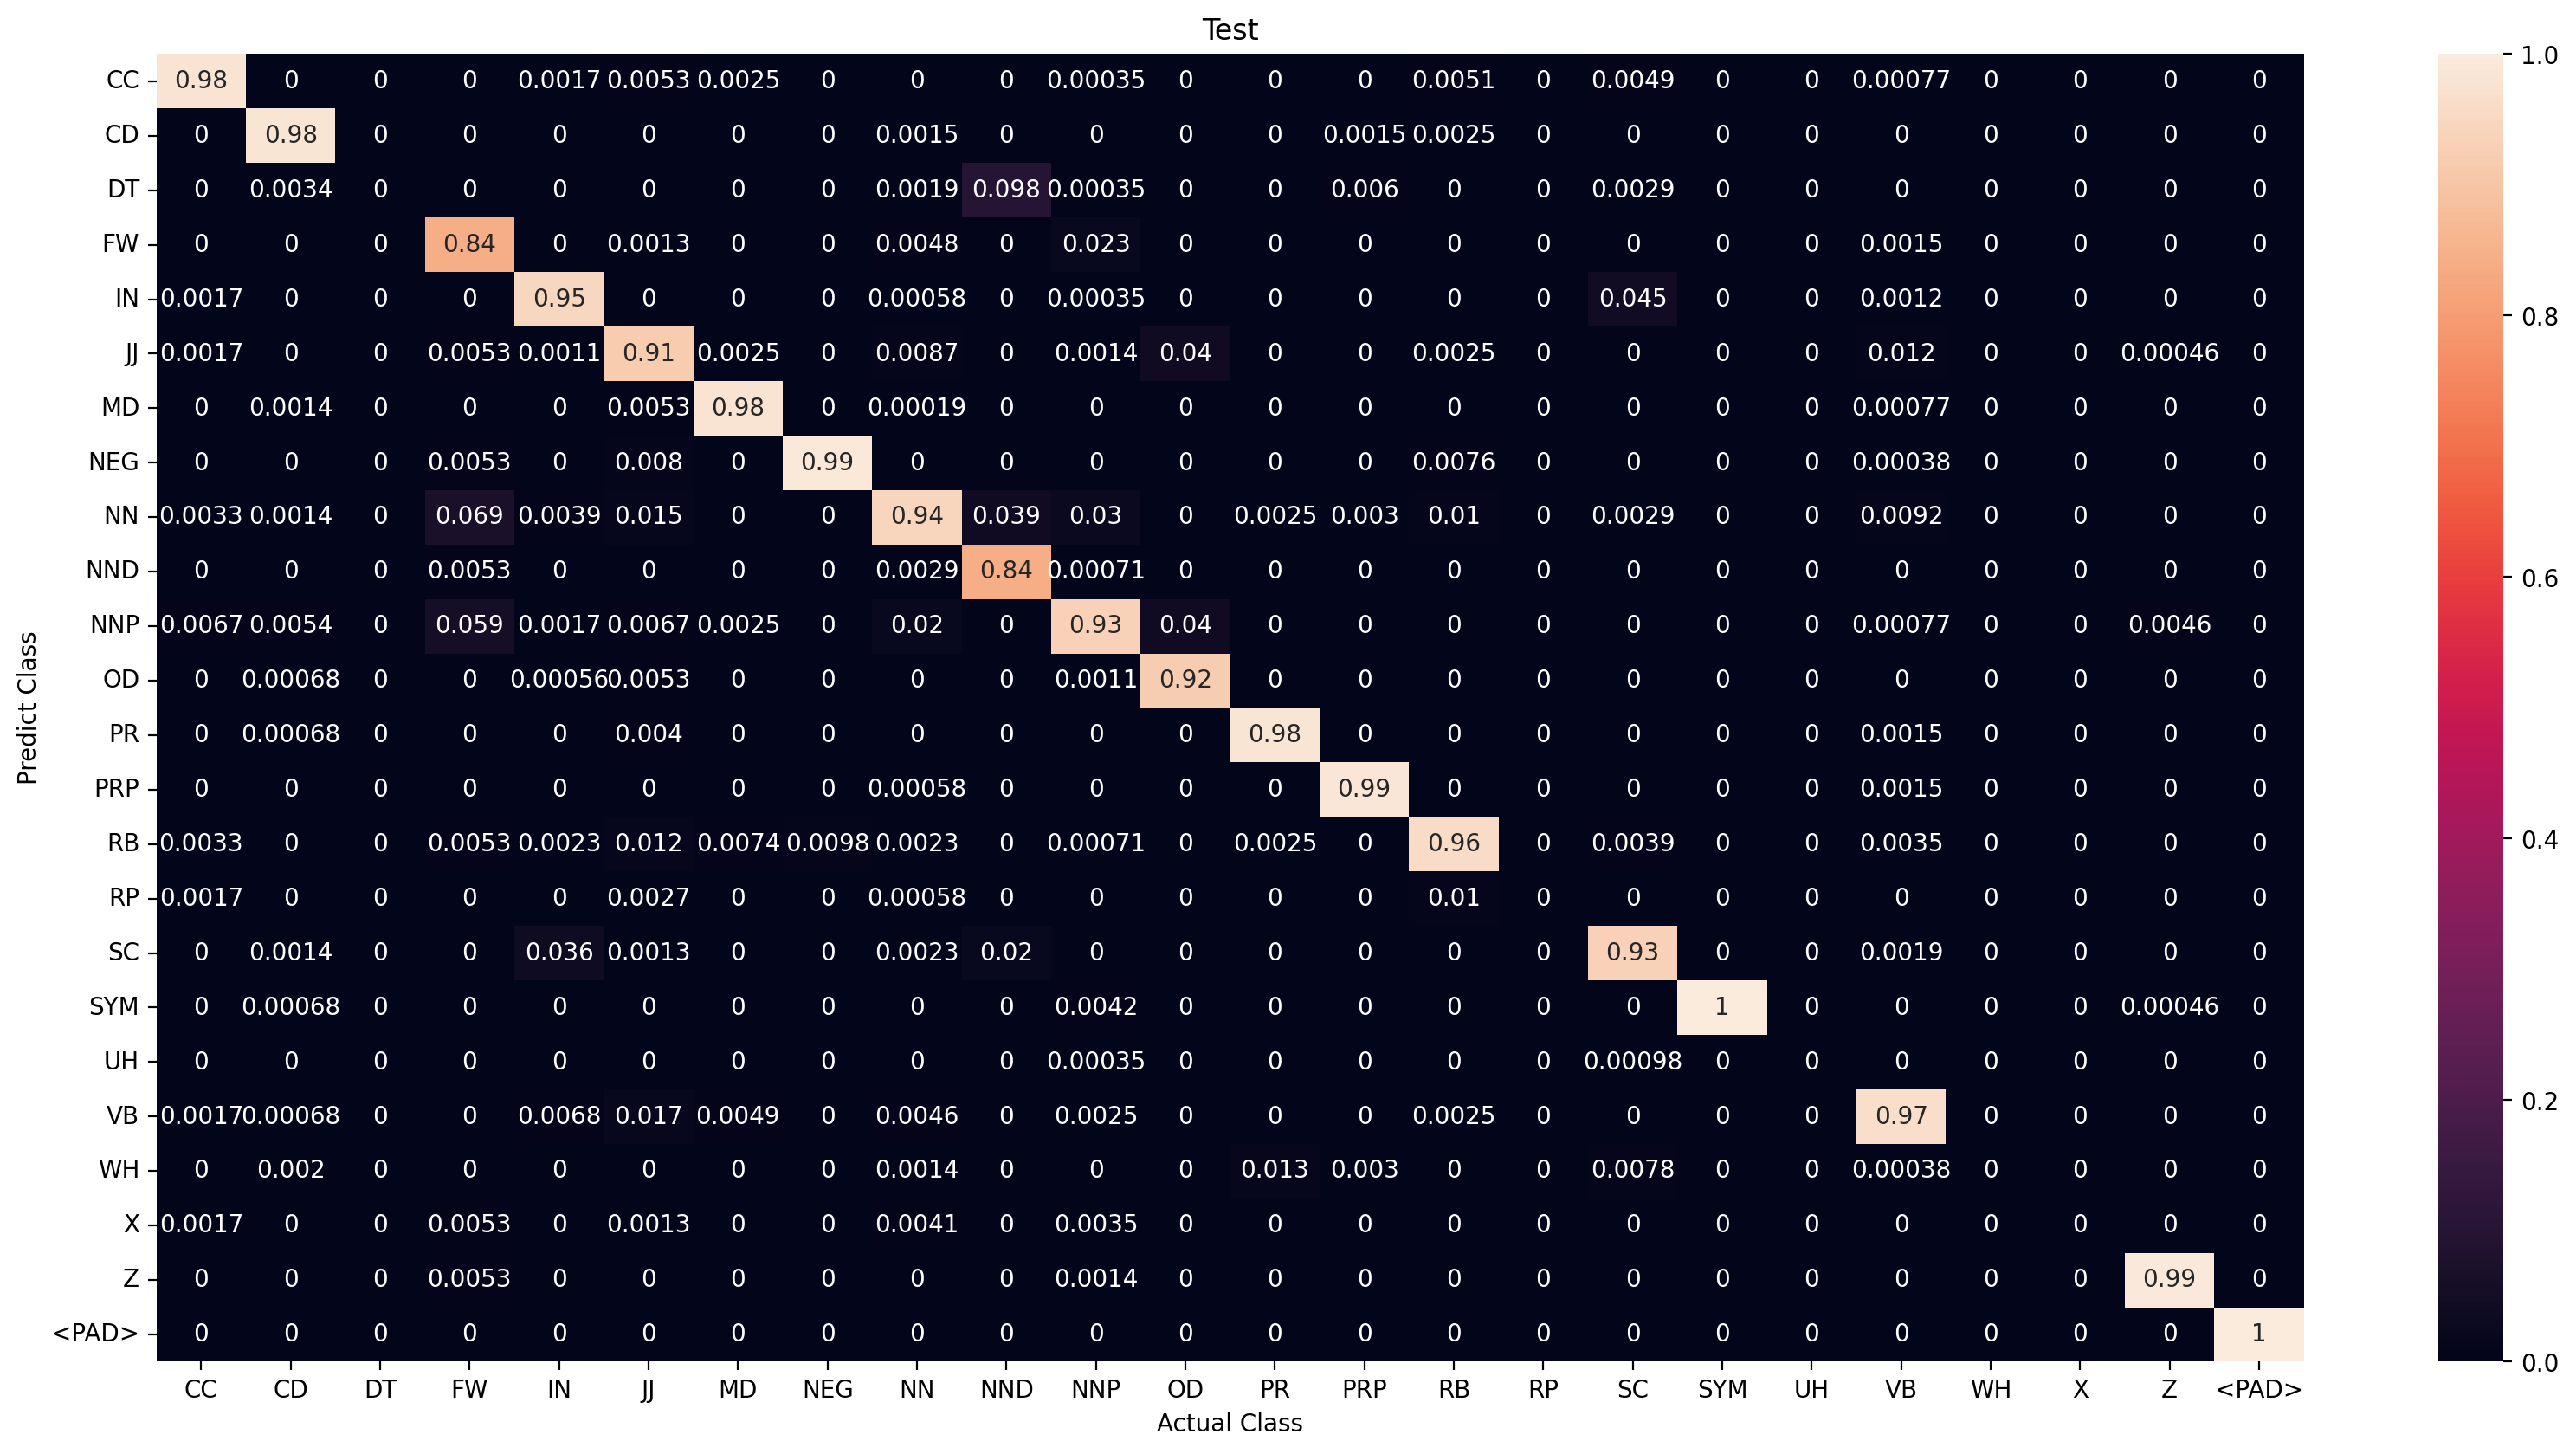

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5202       | CC    : 144      |
| CD    : 12730  | CD    : 12653      | CD    : 77       |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1404       | FW    : 210      |
| IN    : 15342  | IN    : 15226      | IN    : 116      |
| JJ    : 6981   | JJ    : 6589       | JJ    : 392      |
| MD    : 3799   | MD    : 3762       | MD    : 37       |
| NEG   : 1118   | NEG   : 1018       | NEG   : 100      |
| NN    : 44369  | NN    : 43959      | NN    : 410      |
| NND   : 1047   | NND   : 929        | NND   : 118      |
| NNP   : 25175  | NNP   : 24716      | NNP   : 459      |
| OD    : 524    | OD    : 504        | OD    : 20       |
| PR    : 3880   | PR    : 3817       | PR    : 63       |
| PRP   : 5471   | PRP   : 5422       | PRP   : 49       |
| RB    : 3477   | RB    : 3332       | RB    : 145      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11036
Wrong prediction            : 770
Percentage correct oov pred : 93.47789259698457

Validation
Number OOV token            : 3366
Correct prediction          : 2966
Wrong prediction            : 400
Percentage correct oov pred : 88.116458704694

Test
Number OOV token            : 1390
Correct prediction          : 1228
Wrong prediction            : 162
Percentage correct oov pred : 88.34532374100719



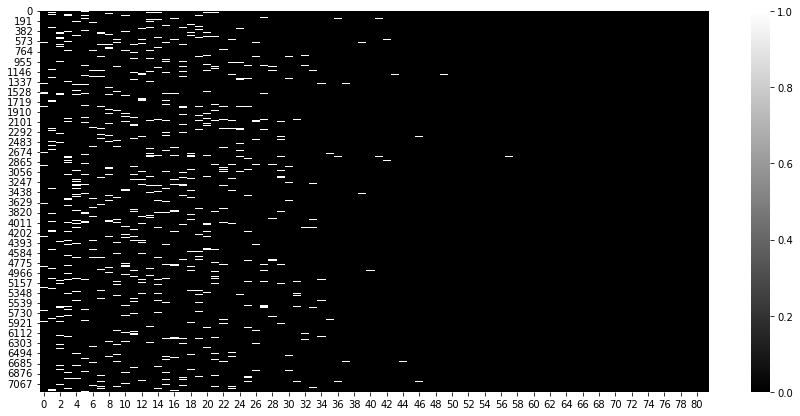

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

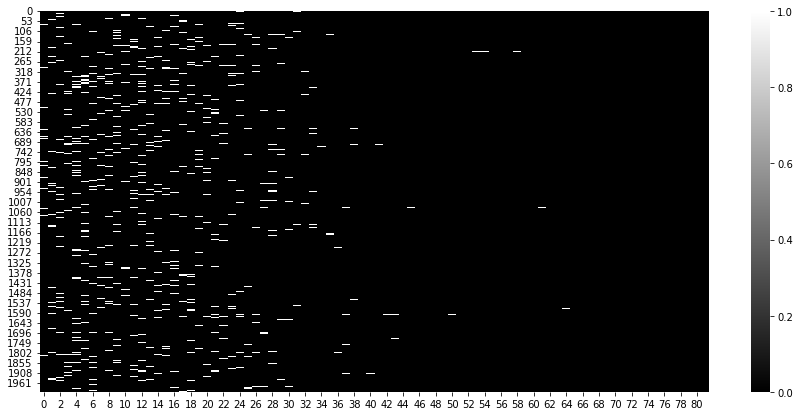

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

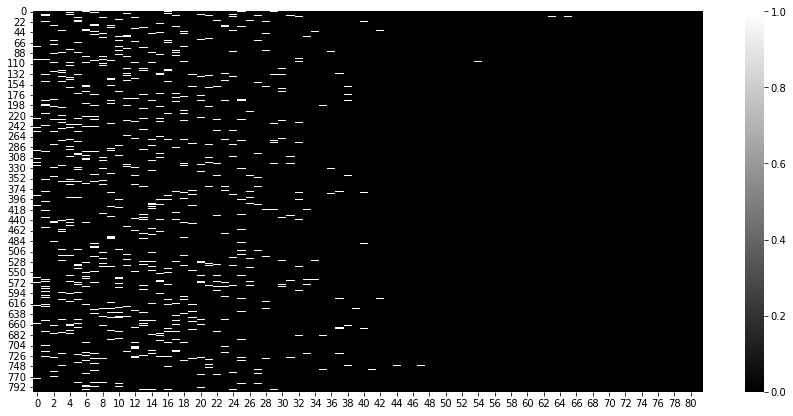

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);